In [1]:
from skimage import io
import nibabel as nib
import os
import numpy as np
import re
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import matplotlib.pyplot as plt
import subprocess
%matplotlib inline

# Import data from cluster

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/sophie/1554f3a2-94a1-4cf8-ae79-8a6fef1b5f7e/100732ss1


In [4]:
path=foldername

In [5]:
Dataname=path.split('/')[-1]

In [6]:
Dataname

'100732ss1'

# Open the images

In [7]:
tt = io.imread(path+'/'+Dataname+'-0010.tif') 
S=tt.shape
S

(30, 103, 105)

In [8]:
file_name_list = sorted(os.listdir(path))

Use the one below to avoid indexing problems

In [9]:
%%time
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
for i,image_file in enumerate(sorted(file_name_list)):
    #print(i)
    tt = io.imread(path+'/'+image_file)
    data[:,:,:,i]=tt[:][:][:]
    

CPU times: user 1min 31s, sys: 8.74 s, total: 1min 40s
Wall time: 1min 40s


%%time
#file_name_list = os.listdir(path)
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
i=0
for j in range(30):
#for j in range(len(file_name_list)):       
#for fn in os.listdir(path):
    tt = io.imread(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    if os.path.exists(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'):
        #print path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'
        tt = io.imread(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif')
        data[:,:,:,i]=tt[:][:][:]
        i=i+1

In [10]:
data.shape

(30, 103, 105, 5450)

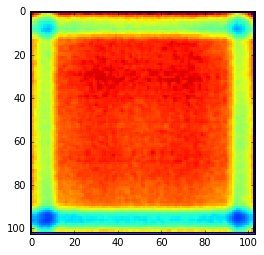

In [10]:
plt.show()
plt.imshow(data[5,:,:,10],interpolation='none')
plt.show()

In [ ]:
%%time
#file_name_list = os.listdir(path)
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
i=0
#for j in range(30):
for j in range(len(file_name_list)):       
#for fn in os.listdir(path):
    #tt = io.imread(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    
    #if os.path.exists(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'):
    if os.path.exists(path+'/'+Dataname+'-'+str(j)+'.tif'):
        #print path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'
        tt = io.imread(path+'/'+Dataname+'-'+str(j)+'.tif')
        #tt = io.imread(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif')
        data[:,:,:,i]=tt[:][:][:]
        i=i+1

In [ ]:
data.shape


# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

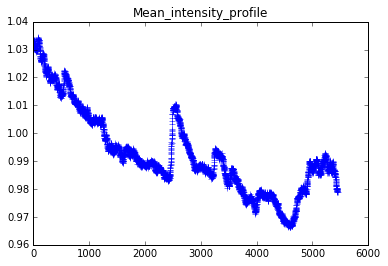

In [11]:
M=np.mean(np.mean(np.mean(data,0),0),0)
Mav=M.mean()
plt.title('Mean_intensity_profile')
plt.plot(M,'+')

### Get approximate on and off times

In [12]:
liston=[i for i in range(len(M)) if M[i]>Mav*0.8]
liston[0]

209

### Model for fitting onset and offset

In [13]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

### Model onset and find precise onset time

In [14]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [15]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [16]:
res = scipy.optimize.minimize(Sq,x0=[7,0.3,9,0.7])
ON=liston[0]-8+res.x[2]
print(ON)

208.995938686


209


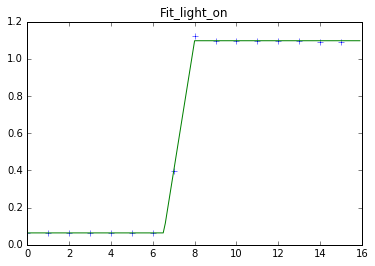

In [21]:
ONint=np.int(np.ceil(ON))
print(ONint)
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.title('Fit_light_on')
plt.show()

Model offset and find precise offset time

In [18]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

IndexError: index 2089 is out of bounds for axis 1 with size 2089

In [ ]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [ ]:
res = scipy.optimize.minimize(Sq,x0=[6,3,8,-1])

In [19]:
OFF=liston[len(liston)-1]-6+res.x[0]
OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

2088
2088


In [ ]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.title('Fit_light_off')
plt.show()

In [ ]:
data.shape

# Open images times

In [ ]:
for f in os.listdir('/home/sophie/Downloads/csvs'):
    if Dataname[:6] in f:
        if f.endswith('csv'):
            TimeFile='/home/sophie/Downloads/csvs/Data'+Dataname[:6]+'_.csv'
            Listfile = open(TimeFile, 'r')
            ListTime = [line.split('\n')[0] for line in Listfile.readlines()]
            Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]
        elif "Original" or "Info" in f:
            TimeFile='/home/sophie/Downloads/csvs/'+f
            with open(TimeFile, 'r') as metafile:
                lines = metafile.readlines()
            time_from_start_list = []
            for line in lines:
                if "Time_From_Start" in line:
                    split_line = line.replace('\t', ' ').replace(' = ', ' ').strip().split(' ')
                    time_from_start_list.append((int(split_line[1]),float(split_line[3])))
            Timespl = list(zip(*sorted(time_from_start_list))[1])
            

In [ ]:
S

# Get times corresponding to images during light on (excitation light completely on : t=0)

In [ ]:
print(ONint)
print(OFFint)
#print(ON)

In [ ]:
(11974-498)*0.05

In [ ]:
len(Timespl)

In [ ]:
TimeOn=[Timespl[i] for i in range(ONint,(OFFint+1))]
Tinit=(ON-(ONint-1))*(Timespl[ONint]-Timespl[ONint-1])+Timespl[ONint-1]
Toff=(OFFint+1-OFF)*(Timespl[OFFint+1]-Timespl[OFFint])+Timespl[OFFint]
Toff-Tinit

In [ ]:
Timespl[ONint]-Timespl[ONint-1]

In [ ]:
TimeOn[0]-Tinit

In [ ]:
Dataname[:6]

In [ ]:
TimeOnFinal=np.array(TimeOn)-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})

In [ ]:
TotalTimeOn=Toff-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TotalTimeOn.mat', {'TotalTimeOn':TotalTimeOn})

# Keep only the frames for which the excitation is on and save

In [12]:
#D4=np.transpose(data[:,:,:,range(ONint,(OFFint))],(2,1,0,3))
D4=np.transpose(data,(2,1,0,3))

#D4=np.transpose(data[:,:,:,range(ONint,40000)],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/media/sophie/1554f3a2-94a1-4cf8-ae79-8a6fef1b5f7e/'+Dataname+'on.nii.gz')

In [ ]:
del data
del D4

# Movement Correction

In [ ]:
bashCommand = "3dvolreg -prefix "+"/media/sophie/Elements/"+Dataname+"onreg.nii "+"/mediasophie/Elements/"+Dataname+"on.nii.gz"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
import matlab.engine


In [ ]:
eng=matlab.engine.start_matlab()

In [ ]:
bashCommand = "matlab -r 'RoughAllSteps.m'"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
%matlab
RoughAllSteps